# Исследование поведения пользователей мобильного приложения

В нашем распоряжении данные пользователей нового мобильного приложения. Необходимо изучить поведение этих пользователей. Основные задачи:
 - Изучить воронку продаж. Узнайть, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
 - Исследовать результаты A/A/B-эксперимента. Гипотеза - изменение шрифта во всём приложении не окажет негативного влияния на пользователей. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выяснить, какой шрифт лучше.
 
Файл с данными содержит записи в логе, каждая из которых — это действие пользователя, или событие.

- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Знакомство с данными

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt
import numpy as np
import math as mth
import seaborn as sns
import plotly.express as px

In [2]:
import plotly.io as pio 
pio.renderers.default = "png" 
svg_renderer = pio.renderers["png"] 
svg_renderer.scale = 1.3

In [3]:
try:
    logs_exp = pd.read_csv('logs_exp.csv', sep='\t')
except:
    logs_exp = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [4]:
logs_exp

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [5]:
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Вывод:**
На первый вгляд данные хорошие - без пропусков и в достаточном для анализа количестве. Выбран необычный тип данных для хранения даты - unix time - для удобства приведем к привычному формату. Имеется расхождение с "змеиным" стилем в заголовках.

## Предобработка данных

In [6]:
# меняем стиль заголовков
logs_exp.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

In [7]:
# меняем тип данных на привычный
logs_exp['event_timestamp'] = pd.to_datetime(logs_exp['event_timestamp'], unit='s')

In [8]:
logs_exp['date'] = logs_exp['event_timestamp'].dt.date
logs_exp['date'] = pd.to_datetime(logs_exp['date'])

In [9]:
print('В таблице', logs_exp.duplicated().sum(), 'явных дубликатов, что составляет',
      round(logs_exp.duplicated().sum() / logs_exp.shape[0] * 100, 2), '%')

В таблице 413 явных дубликатов, что составляет 0.17 %


In [10]:
# избавляемся от дубликатов
logs_exp = logs_exp.drop_duplicates().reset_index(drop=True)

**Вывод:**
В данных были обнаружены ( < 1% от данных) и уничтожены явные дубликаты. Тип данных столбца даты и времени был скорректирован, а также добавлен отдельный столбец с датами. Названия столбцов были скорректированы для удобства. Можно приступать к анализу.

## Анализ данных таблицы

In [11]:
# найдем число уникальных событий
len(logs_exp['event_name'].unique())

5

In [12]:
# найдем число уникальных пользователей
len(logs_exp['device_id_hash'].unique())

7551

In [13]:
# посчитаем среднее количество событий на пользователя
print('Среднее число событий на пользователя:',
      logs_exp.groupby('device_id_hash').agg({'event_name': 'count'})['event_name'].mean())
print("Медианное число событий на пользователя:",
      logs_exp.groupby('device_id_hash').agg({'event_name': 'count'})['event_name'].median())

Среднее число событий на пользователя: 32.27559263673685
Медианное число событий на пользователя: 20.0


In [14]:
# найдем горизонт событий
min_date = logs_exp['date'].min()
max_date = logs_exp['date'].max()

print(min_date, max_date)

2019-07-25 00:00:00 2019-08-07 00:00:00


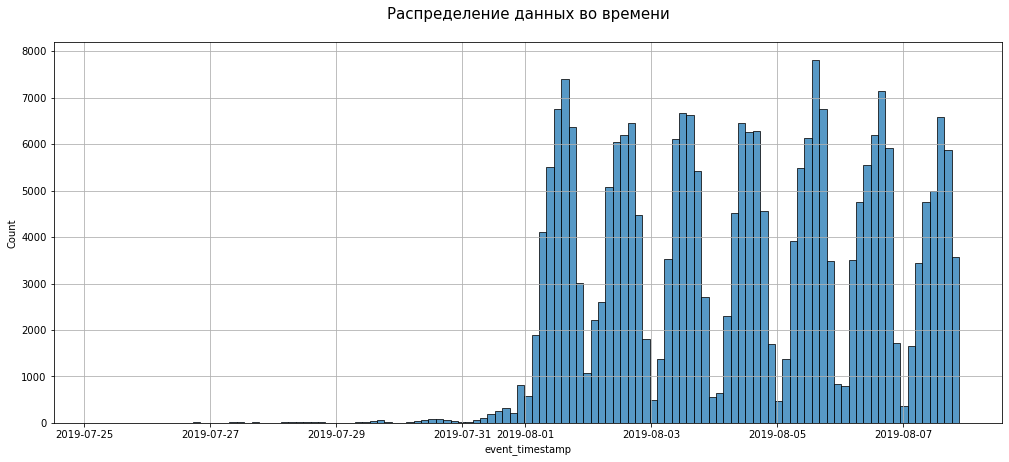

In [15]:
# посмотрим, как распределены ззаписи относительно времени
fig, ax = plt.subplots(figsize=(17, 7))
ax.grid()
ax.set_title('Распределение данных во времени' + '\n', fontsize = 15)
sns.histplot(data=logs_exp['event_timestamp'], ax=ax);
plt.show()

Из графика можно сделать вывод, что данные неравномерно распределены в заданном периоде. Очень сильно заметна разница между числом зиписей до и после отметки 1 августа, а также в дневное и ночное время. Для корректности оставим только август, где данные актуальны,а более старые отбросим.

Тогда реальный горизонт событий с 1 по 7 августа.

In [16]:
# убираем неполные данные
data = logs_exp.query('date >= "2019-08-01"')

In [17]:
# проверим как изменилось число уникальных событий и пользователей
print('После корректировки данных осталось', len(data),
      'уникальных событий. Изменение составляет', len(logs_exp) - len(data), 'записей, т.е.',
      round((len(logs_exp) - len(data)) / len(data), 4))

print('После корректировки данных осталось', len(data['device_id_hash'].unique()),
      'уникальных пользователя. Изменение составляет',
      len(logs_exp['device_id_hash'].unique()) - len(data['device_id_hash'].unique()), 'пользователей, т.е.',
      round((len(logs_exp['device_id_hash'].unique()) - len(data['device_id_hash'].unique())) /
            len(data['device_id_hash'].unique()), 4))

После корректировки данных осталось 240887 уникальных событий. Изменение составляет 2826 записей, т.е. 0.0117
После корректировки данных осталось 7534 уникальных пользователя. Изменение составляет 17 пользователей, т.е. 0.0023


Число  событий и число уникальных пользователей сократилось, но не критично.

Теперь проверим, что у нас есть пользователи из всех групп тестирования, заодно проверим их соотношение.

In [18]:
data['exp_id'].unique()

array([246, 247, 248], dtype=int64)

**Вывод:**
В данных была обнаружена неравномерность относительно времени. После среза полных данных были потеряны события и уникальные пользователи в небольшом количестве (не больше  1%). Представители всех групп остались в срезе.

## Формирование и анализ воронки

In [19]:
# посмотрим, какие есть события и как часто они встречаются
data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

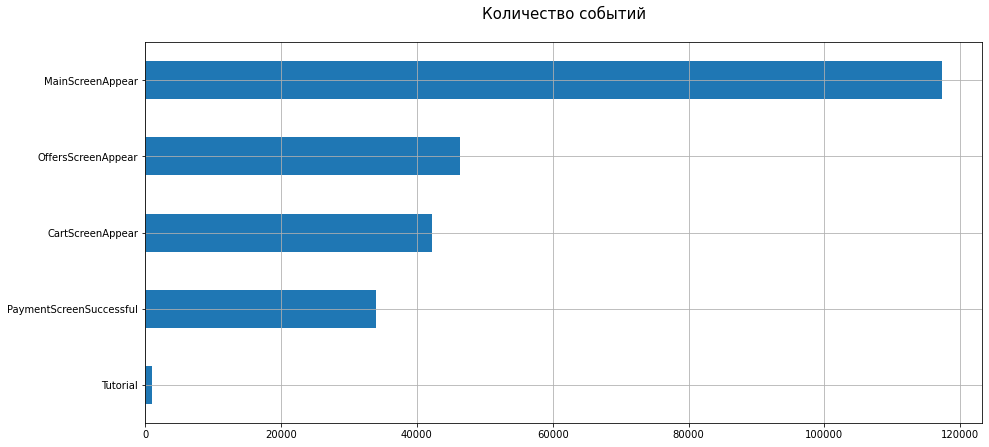

In [20]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title('Количество событий' + '\n', fontsize = 15)
data['event_name'].value_counts().sort_values().plot(kind='barh', ax=ax, grid=True)
plt.show()

In [21]:
# посмотрим, сколько уникальных пользователей совершили каждое событие
uniq_users_per_event = (
    data
    .groupby('event_name')
    .agg({'device_id_hash': 'nunique'})
)
uniq_users_per_event.sort_values(by='device_id_hash', ascending=False)

,device_id_hash
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


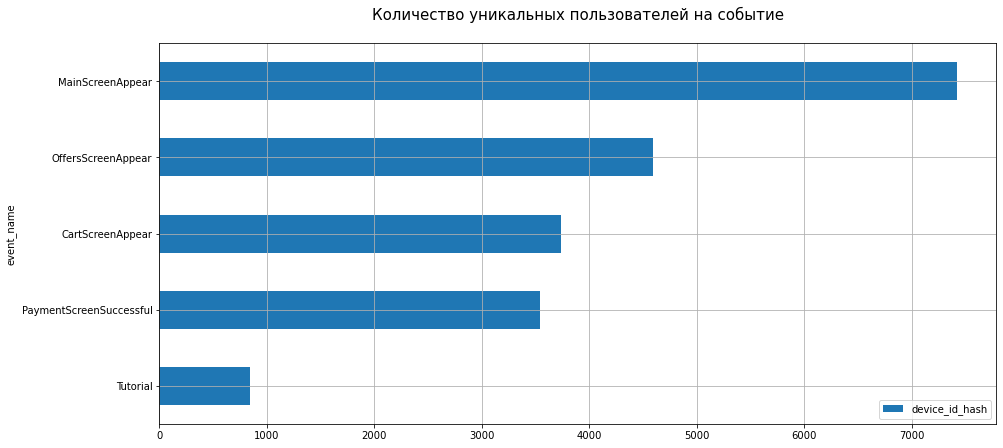

In [22]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title('Количество уникальных пользователей на событие' + '\n', fontsize = 15)
(
    uniq_users_per_event
    .sort_values(by='device_id_hash')
    .plot(kind='barh', ax=ax, grid=True)
)
plt.show()

In [23]:
# число уникальных пользователей
uniq_users_count = data['device_id_hash'].nunique()

# расчитаем какова доля пользователей, которые хоть раз совершали событие
uniq_users_per_event['share'] = round(uniq_users_per_event['device_id_hash'] / uniq_users_count, 3)

uniq_users_per_event.sort_values(by='device_id_hash', ascending=False)

,device_id_hash,share
event_name,,
MainScreenAppear,7419,0.985
OffersScreenAppear,4593,0.610
CartScreenAppear,3734,0.496
PaymentScreenSuccessful,3539,0.470
Tutorial,840,0.111


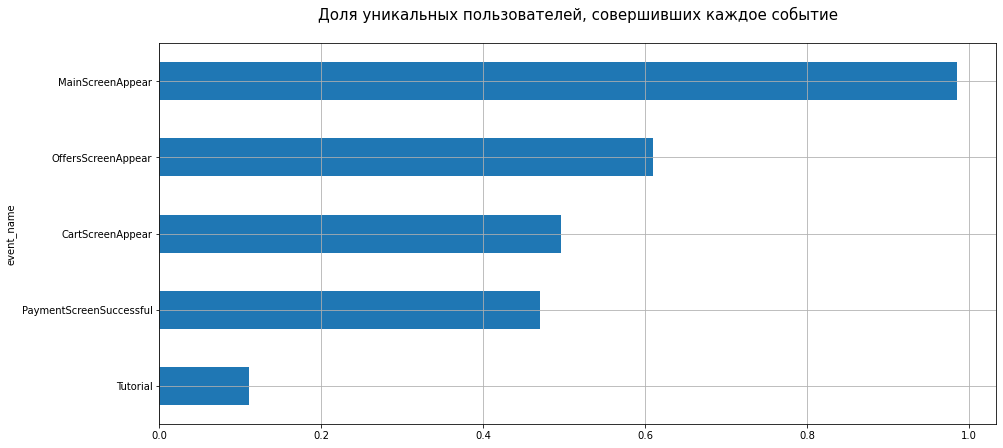

In [24]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title('Доля уникальных пользователей, совершивших каждое событие' + '\n', fontsize = 15)
(
    uniq_users_per_event['share']
    .sort_values()
    .plot(kind='barh', ax=ax, grid=True)
)
plt.show()

Из двух приведенных графиков можно сделать вывод, что события происходят в следующем порядке:
 - MainScreenAppear
 - OffersScreenAppear
 - CartScreenAppear
 - PaymentScreenSuccessful

А также где-то на начальных этапах можно пройти или пропустить Tutorial. Так как этот этап является, скорее всего (ввиду своей малочисленности), необязательным, мы не будем включать его в воронку.

Составим таблицу с воронкой и ее конверсией в целом и по этапам.

In [25]:
uniq_users_per_event = (
    uniq_users_per_event
    .sort_values(by='device_id_hash', ascending=False)
    .iloc[:-1]
    
    )
share = [uniq_users_per_event['device_id_hash'][i] / uniq_users_per_event['device_id_hash'][i - 1] 
         for i in range(len(uniq_users_per_event['device_id_hash']))]
share[0] = 1
uniq_users_per_event['share_per_step'] = share
uniq_users_per_event

,device_id_hash,share,share_per_step
event_name,,,
MainScreenAppear,7419,0.985,1.000000
OffersScreenAppear,4593,0.610,0.619086
CartScreenAppear,3734,0.496,0.812976
PaymentScreenSuccessful,3539,0.470,0.947777


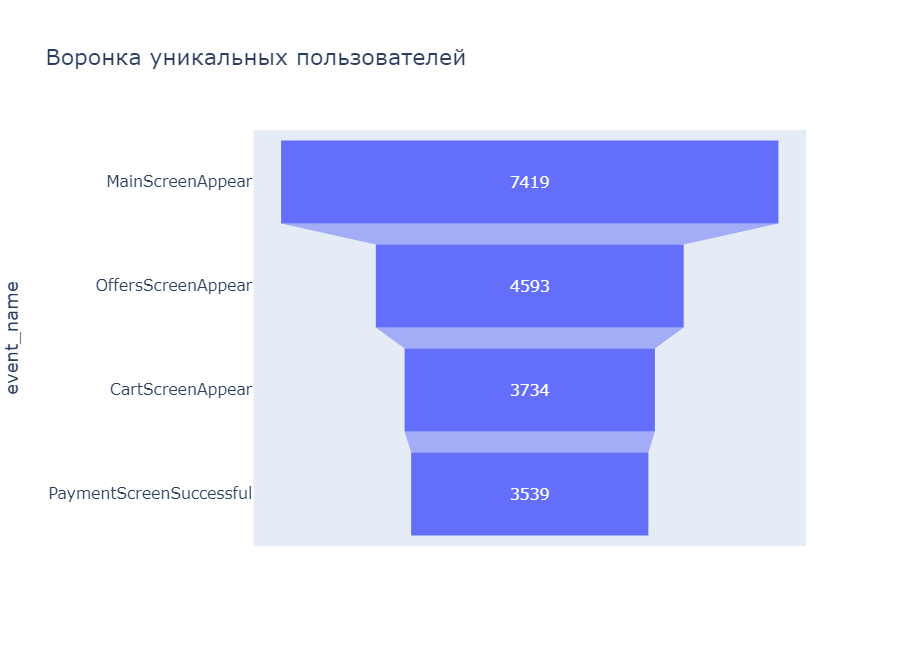

In [26]:
fig = px.funnel(uniq_users_per_event, x='device_id_hash', title='Воронка уникальных пользователей')
fig.show()

Построив воронку мы получили следующие результаты. Больше всего людей отсеивается уже при переходе на второй шаг - почти 40% не переходят. Зато на последний шаг переходят почти все пользователи.

Еще один важный момент - это различие между числом уникальных пользователей на первом шаге воронки и суммой уникальных людей в срезе. Это может быть связано либо с отсеиванием еще на этапе обучения (если предположить, что он наступает до перехода на главную страницу), либо пользователи перешли со стороннего ресурса сразу на страницу предложений.

Также из таблицы-воронки видно, что путь до конца проходит чуть меньше половины пользователей (47%), при этом в основном они отсеиваются сразу после первого шага.

**Вывод:**
В этой части анализа мы рассмотрели сколько людей пользуется предложениями приложения. Составили воронку на основе числа пользователей, выявили необязательный этап - Tutorial, а также расчитали насколько активно пользователи переходят с одного шага воронки на другой. Выяснили, что уже после первого шага отсеивается почти 40% пользователей, что ставит под сомнение удобство и легкость перехода. Также стоит учесть, что некоторые пользователи сразу перешли на второй этап со сторонненго ресурса, из-за чего процент конверсии пользователей становится еще меньше. Однако почти все, кто дошел до этого шага, доходят до конца воронки. В совокупности всю воронку проходит чуть меньше половины пользователей - 47%.

## Изучение результатов тестирования

In [27]:
# сколько пользователей в каждой группе
data.groupby('exp_id').agg({'device_id_hash': 'nunique'})

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


Количество человек в во всех группах различно, но не сильно. Проверим, нет ли пересечений в группах.

In [28]:
data.groupby('device_id_hash').agg({'exp_id': 'nunique'}).query('exp_id > 1').count()

exp_id    0
dtype: int64

Уникальных пользователей на пересечении нет.

Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Проверим гипотезу, о том что конверсия в покупателей у группы 246 и 247 одинаковые:
 - Нулевая гипотеза: доли уникальных посетителей, побывавших на этапе воронки, одинаковы.
 - Альтенативная гипотеза: между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.

In [29]:
# составим сводную таблицу - воронка для каждой группы эксперимента

voronka_contr = (
    data
    .query('exp_id in [246, 247]')
    .pivot_table(index='exp_id', columns='event_name', values='device_id_hash',
                 aggfunc='nunique', margins=True, margins_name='246_247')
)
voronka_contr = voronka_contr.rename(columns={'246_247': 'All'})
voronka_exp = (
    data
    .query('exp_id == 248')
    .pivot_table(index='exp_id', columns='event_name', values='device_id_hash',
                 aggfunc='nunique', margins=True)
)
voronka = pd.concat([voronka_contr, voronka_exp]).iloc[:-1]
voronka = voronka[['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'All']]

voronka

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,All
exp_id,,,,,
246,2450,1542,1266,1200,2484
247,2476,1520,1238,1158,2513
246_247,4926,3062,2504,2358,4997
248,2493,1531,1230,1181,2537


In [30]:
# выберем уровень значимости
alpha = 0.05

In [31]:
# напишем функцию, которая проверяет равенство долей групп
# где параметр event принимает значения события в воронке до которого дошли пользователи
# MainScreenAppear,  OffersScreenAppear,  CartScreenAppear,  PaymentScreenSuccessful
# параметры group1 и group2 принимают значения сравнимаемых групп

def is_there_diff(group1, group2, event):
    last_step = np.array([voronka.loc[group1, event],
                          voronka.loc[group2, event]])
    
    first_step = np.array([voronka.loc[group1, 'All'], voronka.loc[group2, 'All']])
    
    p1 = last_step[0] / first_step[0]
    p2 = last_step[1] / first_step[1]
    p_combined = (last_step[0] + last_step[1]) / (first_step[0] + first_step[1])
    
    z_value = (p1 - p2) / mth.sqrt(p_combined * (1 - p_combined) * (1 / first_step[0] + 1 / first_step[1]))
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями уникальных пользователей, побывавших на этапе',
              event, 'есть значимая разница')
    else:
        print('''Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей,
побывавших на этапе''', event, 'разными')

In [32]:
is_there_diff(246, 247, 'PaymentScreenSuccessful')

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей,
побывавших на этапе PaymentScreenSuccessful разными


Самым популярным событием очевидно является первое событие - MainScreenAppear. Посмотрим сколько людей совершили это действие в контрольных группах и на доли пользователей, которые дошли до этого этапа (по идее это число 1, потому что это первый этап, но так как у нас есть пользователи, которые почему-то не дошли до этого этапа, то доля будет чуть ниже).

In [33]:
# напишем функцию, которая будет сообщать нам число и долю пользователей, дошедших до определенного шага воронки
def func(group, event):
    print(f'''В {group} группе до этапа {event} дошло {voronka.loc[group, event]} пользователей.
Это составляет {round(voronka.loc[group, event] / voronka.loc[group, 'All'], 2)} от общего числа пользователей группы.''')
    print()

In [34]:
func(246, 'MainScreenAppear')
func(247, 'MainScreenAppear')
is_there_diff(246, 247, 'MainScreenAppear')

В 246 группе до этапа MainScreenAppear дошло 2450 пользователей.
Это составляет 0.99 от общего числа пользователей группы.

В 247 группе до этапа MainScreenAppear дошло 2476 пользователей.
Это составляет 0.99 от общего числа пользователей группы.

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей,
побывавших на этапе MainScreenAppear разными


Для самого популярного события разницы в значениях не является статистичестки значимой.

Проверим остальные этапы.

In [35]:
func(246, 'OffersScreenAppear')
func(247, 'OffersScreenAppear')

is_there_diff(246, 247, 'OffersScreenAppear')

В 246 группе до этапа OffersScreenAppear дошло 1542 пользователей.
Это составляет 0.62 от общего числа пользователей группы.

В 247 группе до этапа OffersScreenAppear дошло 1520 пользователей.
Это составляет 0.6 от общего числа пользователей группы.

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей,
побывавших на этапе OffersScreenAppear разными


Для события OffersScreenAppear также не обнаружена статистическая значимость в разнице.

In [36]:
func(246, 'CartScreenAppear')
func(247, 'CartScreenAppear')

is_there_diff(246, 247, 'CartScreenAppear')

В 246 группе до этапа CartScreenAppear дошло 1266 пользователей.
Это составляет 0.51 от общего числа пользователей группы.

В 247 группе до этапа CartScreenAppear дошло 1238 пользователей.
Это составляет 0.49 от общего числа пользователей группы.

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей,
побывавших на этапе CartScreenAppear разными


Для события CartScreenAppear также не была обнаружена статистическая значимость в разнице между контрольными группами.

Итого, получаем, что контрольные группы, хоть на первый взгляд кажутся не совсем одинаковыми, не имеют статистически значимой разницы. А значит разбиение на группы работает корректно, можно исследовать экспериментальную группу.

In [37]:
# рассмотрим разницу группы 246 с экспериментальной группой
# разница по первому событию MainScreenAppear
func(248, 'MainScreenAppear')
is_there_diff(246, 248, 'MainScreenAppear')
print()

# разница по второму событию OffersScreenAppear
func(248, 'OffersScreenAppear')
is_there_diff(246, 248, 'OffersScreenAppear')
print()

# разница по третьему событию CartScreenAppear
func(248, 'CartScreenAppear')
is_there_diff(246, 248, 'CartScreenAppear')
print()

# разница по последнему событию PaymentScreenSuccessful
func(248, 'PaymentScreenSuccessful')
is_there_diff(246, 248, 'PaymentScreenSuccessful')
print()

В 248 группе до этапа MainScreenAppear дошло 2493 пользователей.
Это составляет 0.98 от общего числа пользователей группы.

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей,
побывавших на этапе MainScreenAppear разными

В 248 группе до этапа OffersScreenAppear дошло 1531 пользователей.
Это составляет 0.6 от общего числа пользователей группы.

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей,
побывавших на этапе OffersScreenAppear разными

В 248 группе до этапа CartScreenAppear дошло 1230 пользователей.
Это составляет 0.48 от общего числа пользователей группы.

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей,
побывавших на этапе CartScreenAppear разными

В 248 группе до этапа PaymentScreenSuccessful дошло 1181 пользователей.
Это составляет 0.47 от общего

Статистической значимости у разницы между первой контрольной группой и экспериментальной в доли перешедших на каждый из этапов воронки нет.

In [38]:
# рассмотрим разницу группы 247 с экспериментальной группой
# разница по первому событию MainScreenAppear
is_there_diff(247, 248, 'MainScreenAppear')
print()
# разница по второму событию OffersScreenAppear
is_there_diff(247, 248, 'OffersScreenAppear')
print()
# разница по третьему событию CartScreenAppear
is_there_diff(247, 248, 'CartScreenAppear')
print()
# разница по последнему событию PaymentScreenSuccessful
is_there_diff(247, 248, 'PaymentScreenSuccessful')
print()

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей,
побывавших на этапе MainScreenAppear разными

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей,
побывавших на этапе OffersScreenAppear разными

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей,
побывавших на этапе CartScreenAppear разными

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей,
побывавших на этапе PaymentScreenSuccessful разными



Со второй группой получили такой же результат. Теперь посмотрим на разницу между экспериментальной группой и контрольной в совокупности.

In [39]:
# рассмотрим разницу между суммарными показателями контрольных групп и экспериментальной группой
# разница по первому событию MainScreenAppear
is_there_diff('246_247', 248, 'MainScreenAppear')
print()
# разница по второму событию OffersScreenAppear
is_there_diff('246_247', 248, 'OffersScreenAppear')
print()
# разница по третьему событию CartScreenAppear
is_there_diff('246_247', 248, 'CartScreenAppear')
print()
# разница по последнему событию PaymentScreenSuccessful
is_there_diff('246_247', 248, 'PaymentScreenSuccessful')
print()

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей,
побывавших на этапе MainScreenAppear разными

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей,
побывавших на этапе OffersScreenAppear разными

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей,
побывавших на этапе CartScreenAppear разными

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей,
побывавших на этапе PaymentScreenSuccessful разными



Статистически значимой разницы между контрольной группой в совокупности и экспериментальной группой также не обнаружено.

Из эксперимента можно сделать вывод, что смена шрифта никак не повлияла на покупаемость продукта в приложении.

Для проверки статистических гипотез я выбрала уровень значимости равный 0.05. В процессе исследования было проведено 16 проверок для 4 групп, т.е. каждая группа сравнивалась с другой по 8 раз (кроме объеденения контрольных групп). Для моего уровня значимости каждая 20 проверка может привести к ошибке первого рода, но так как идет множественное сравнение  между 4 группами, вероятность получить ложноположительный результат сильно увеличивается. Чтобы уменьшить вероятость ошибки первого рода α уменьшают по одному из правил, например, методом Шидака, где $α_i = 1 - (1 - α)^{1/m}$. Однако все проверки не выявили различий между группами, поэтому понижение уровня значимости не требуется.

**Вывод:**
В процессе проверки гипотез не было выявлено различий в доле пользователей, доходивших до разных этапов воронки. Разница проверялась между контрольными группами, каждой из контрольных групп и экспериментальной и контрольной группой в совокупности и экспериментальной.

# Вывод

В процессе предобработки и анализа данных были обнаружены дубликаты и наличие старых логов. После среза актуальных данных было потеряно около 1% записей и <1% уникальных пользователей. Все это могло сказаться на дальнийших результатах эксперимента. Рекомендую проверить качество загрузки данных в таблицу.


Сформировав воронку, мы получили следующие результаты:
 - процесс покупки у большинства* пользователей приложения занимает 4 этапа:
   - просмотр главной страницы
   - просмотр предложений
   - просмотр корзины
   - успешная оплата покупки
 
 - до последнего этапа доходит 47% пользователей
 - больше всего пользователей застревает / отсеивается между первым и вторым шагом воронки - 38% отсеивается

*Интересно заметить, что не все пользователи воронки побывали на первом этапе, вероятно перейдя со сторонних ресурсов.

Рекомендую изучить переход с главной страницы на страницу предложений. Возможно, усовершествование данного этапа повысит конверсию пользователей в покупателей.


На этапе анализа самого эксперимента было выявлено, что смена шрифта не оказала никакого влияния на конверсию покупателей. Проверка гипотез на отсутсвие статистически значимой разницы в доле пользователей разных групп дошедших до одного из этапов воронки не удалось отвергнуть. 
Таким образом, переживания менеджеров о непривычности шрифта в приложения напрасны.

В результатах работы А/В теста (А/А/В теста) можно быть уверенным, ввиду отсутсвия разницы между контрольными группами.